# Subdistrict Exploratory Data Analysis

In this notebook, we extend our exploratory analysis to the **subdistrict (Ortsteil)** level. While Bezirk-level data provided an overview, analyzing 96 Ortsteile allows for a more granular understanding of affordability, demographic variation, and neighborhood characteristics. This finer scale is essential for making localized recommendations on where households might afford to live in Berlin.

📌 `Key Insights`

* **High Variation Within districts**: Even within the same district, subdistricts vary strongly in rent, income, and demographic composition, highlighting the need for analysis beyond Bezirk averages.

* **Affordability Hotspots**: Certain Ortsteile emerge as relatively affordable despite being located in otherwise expensive Bezirke.

* **Population Structure**: Younger populations cluster in inner-city, vibrant areas, while outer districts often have higher shares of seniors.

* **Amenities & Services**: POI data shows stark contrasts in access to cafes, bars, libraries, and green spaces, shaping neighborhood attractiveness.

* **Feature Correlations**: As at the Bezirk level, some features are strongly correlated (population vs. households), but others (e.g., POIs vs. income) add complementary information.

📌 `Conclusion`

The Ortsteil-level analysis provides the granularity required for meaningful affordability modeling. By combining rent, income, demographics, and POIs at this scale, we prepare a strong foundation for clustering neighborhoods into profiles and building a recommender system that reflects the diversity of Berlin’s housing landscape.

# Environment & Data

We prepare the enviromnet for EDA and load the created subdistrict master table (including scraped POIs)

In [55]:
# Bootstrap
import sys, os
import pandas as pd
import numpy as np

# Add repo root to path so imports work
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from berlin_housing import config

# Vizualization settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [56]:
# Load subdistrict master table
ortsteil_master = pd.read_csv(os.path.join(config.PROCESSED_DIR, "ortsteil_master_with_poi.csv"))

**Helpers & Utils**

In [57]:
# Handy column groups
age_cols = [
    'subdistrict_population_age_0_5','subdistrict_population_age_5_10','subdistrict_population_age_10_15',
    'subdistrict_population_age_15_20','subdistrict_population_age_20_25','subdistrict_population_age_25_30',
    'subdistrict_population_age_30_35','subdistrict_population_age_35_40','subdistrict_population_age_40_45',
    'subdistrict_population_age_45_50','subdistrict_population_age_50_55','subdistrict_population_age_55_60',
    'subdistrict_population_age_60_65','subdistrict_population_age_65_70','subdistrict_population_age_70_75',
    'subdistrict_population_age_75_80','subdistrict_population_age_80_85','subdistrict_population_age_85_90',
    'subdistrict_population_age_90_95','subdistrict_population_age_95_plus'
]

gender_cols = ['subdistrict_male_population','subdistrict_female_population']
demo_cols = age_cols + gender_cols + [
    'total_population','subdistrict_senior_population','subdistrict_youth_population',
    'subdistrict_senior_share','subdistrict_youth_share','subdistrict_middle_age_population'
]

rent_income_cols = ['subdistrict_avg_median_income_eur','subdistrict_avg_mietspiegel_classification',
                    'classification_category']

employment_cols = ['subdistrict_total_full_time_employees']

poi_cols = [
    'alcohol','animal_training','antiques','art','bar','bathing_place','books','butcher','childcare','clothes',
    'community_centre','confectionery','convenience','deli','dog_park','electronics','fitness_station','florist',
    'fountain','games','garden','greenfield','greengrocer','hairdresser','ice_cream','kiosk','marina',
    'nature_reserve','nightclub','parking','pitch','playground','restaurant','second_hand','stationery','supermarket',
    'theatre','travel_agency','vacant','wine','yes','cafes','bakeries','green_space','schools','medical'
]

id_cols = ['bezirk','ortsteil']

# --- 1) Define broader age buckets and order
bucket_map = {
    'subdistrict_population_age_0_5':'0–14',
    'subdistrict_population_age_5_10':'0–14',
    'subdistrict_population_age_10_15':'0–14',

    'subdistrict_population_age_15_20':'15–24',
    'subdistrict_population_age_20_25':'15–24',

    'subdistrict_population_age_25_30':'25–39',
    'subdistrict_population_age_30_35':'25–39',
    'subdistrict_population_age_35_40':'25–39',

    'subdistrict_population_age_40_45':'40–54',
    'subdistrict_population_age_45_50':'40–54',
    'subdistrict_population_age_50_55':'40–54',

    'subdistrict_population_age_55_60':'55–64',

    'subdistrict_population_age_60_65':'65–79',
    'subdistrict_population_age_65_70':'65–79',
    'subdistrict_population_age_70_75':'65–79',
    'subdistrict_population_age_75_80':'65–79',

    'subdistrict_population_age_80_85':'80+',
    'subdistrict_population_age_85_90':'80+',
    'subdistrict_population_age_90_95':'80+',
    'subdistrict_population_age_95_plus':'80+'
}
bucket_order = ['0–14','15–24','25–39','40–54','55–64','65–79','80+']

# Long age data with shares + bucket
age_long = (
    ortsteil_master[id_cols + ['total_population'] + age_cols]
      .assign(total_population=lambda d: d['total_population'].replace(0, np.nan))
      .melt(id_vars=id_cols + ['total_population'], value_vars=age_cols,
            var_name='age_band', value_name='count')
      .assign(bucket=lambda d: d['age_band'].map(bucket_map))
      .dropna(subset=['bucket', 'total_population'])
      .assign(share=lambda d: d['count'] / d['total_population'])
)

# limit to top-N by population for readability
topN = (ortsteil_master[['ortsteil','total_population']]
        .nlargest(20, 'total_population')['ortsteil'])
age_long_top = age_long[age_long['ortsteil'].isin(topN)]

# Aggregate to bucket shares and sort rows by youth share
hm = (
    age_long_top.groupby(['ortsteil','bucket'], as_index=False)['share'].sum()
    .pivot(index='ortsteil', columns='bucket', values='share')
    .reindex(columns=bucket_order)
    .fillna(0.0)
)
row_order = hm[['0–14','15–24']].sum(axis=1).sort_values(ascending=False).index  # youngest → oldest
hm = hm.loc[row_order]

def cols_like(df, *substrings):
    subs = tuple(substrings)
    return [c for c in df.columns if any(s in c for s in subs)]

# POI groups only (no age groups)
POI_GROUPS = {
    "daily_needs":   ["supermarket", "convenience", "kiosk", "bakery", "greengrocer"],
    "food_drink":    ["restaurant", "cafe", "bar"],
    "nightlife":     ["nightclub"],
    "education":     ["school", "childcare", "kindergarten"],
    "health":        ["medical", "doctor", "pharmacy", "hospital"],
    "parks":         ["park", "garden", "greenfield", "playground", "forest"],
    "sport":         ["fitness_station", "pitch", "sports_centre"],
    "culture":       ["theatre", "books", "museum", "cinema"],
}

import numpy as np
import pandas as pd

# --- 1) Define ID columns and population col (adjust if yours differ)
# id_cols = ['bezirk', 'ortsteil']  # or whatever you use
pop = ortsteil_master['total_population'].replace(0, np.nan)

# --- 2) Map target names -> source columns (accepts variants)
poi_map = {
    'supermarket': ['supermarket'],
    'cafes':       ['cafes', 'cafe'],
    'schools':     ['schools', 'school'],
    'medical':     ['medical', 'doctor', 'pharmacy', 'hospital'],
    'playground':  ['playground'],
    'restaurant':  ['restaurant'],
}

# --- 3) Sum sources and convert to per‑1k
poi_counts = pd.DataFrame(index=ortsteil_master.index)
for target, candidates in poi_map.items():
    cols = [c for c in ortsteil_master.columns
            if c in candidates or any((cand in c) for cand in candidates)]
    if len(cols) == 0:
        # create empty column if nothing found (prevents KeyErrors)
        poi_counts[target] = 0
        print(f"Warning: no columns found for '{target}' – created zeros.")
    else:
        poi_counts[target] = ortsteil_master[cols].sum(axis=1)

poi_per_1k = pd.concat(
    [ortsteil_master[id_cols], (poi_counts.div(pop, axis=0) * 1000)],
    axis=1
).fillna(0)

# Dataset Overview

We begin by describing the Ortsteil dataset, covering **population**, **rent**, **income**, and **POIs** (Points Of Interests). 

This includes data validation steps and ensuring consistency with the Bezirk-level overview.


In [58]:
# Look at first 5 rows of the dataset
ortsteil_master.head()

,bezirk,ortsteil,subdistrict_population_age_0_5,subdistrict_population_age_5_10,subdistrict_population_age_10_15,subdistrict_population_age_15_20,subdistrict_population_age_20_25,subdistrict_population_age_25_30,subdistrict_population_age_30_35,subdistrict_population_age_35_40,subdistrict_population_age_40_45,subdistrict_population_age_45_50,subdistrict_population_age_50_55,subdistrict_population_age_55_60,subdistrict_population_age_60_65,subdistrict_population_age_65_70,subdistrict_population_age_70_75,subdistrict_population_age_75_80,subdistrict_population_age_80_85,subdistrict_population_age_85_90,subdistrict_population_age_90_95,subdistrict_population_age_95_plus,subdistrict_male_population,subdistrict_female_population,total_population,subdistrict_senior_population,subdistrict_youth_population,subdistrict_senior_share,subdistrict_youth_share,subdistrict_middle_age_population,Unnamed: 0,subdistrict_avg_mietspiegel_classification,subdistrict_total_full_time_employees,subdistrict_avg_median_income_eur,classification_category,alcohol,animal_training,antiques,art,bar,bathing_place,books,butcher,childcare,clothes,community_centre,confectionery,convenience,deli,dog_park,electronics,fitness_station,florist,fountain,games,garden,greenfield,greengrocer,hairdresser,ice_cream,kiosk,marina,nature_reserve,nightclub,parking,pitch,playground,restaurant,second_hand,stationery,supermarket,theatre,travel_agency,vacant,wine,yes,cafes,bakeries,green_space,schools,medical
0,treptow-koepenick,adlershof,1177.0,846.0,710.0,671.0,1410.0,1765.0,2274.0,1833.0,1349.0,1044.0,1235.0,1384.0,991.0,833.0,607.0,764.0,762.0,383.0,150.0,22.0,10200,10010,20210,3521.0,3404.0,0.174221,0.168431,0.657348,81,1.806202,428667.0,4388.000000,moderate,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,33,0,0,10,0,0,0,0,1,11,1,215,17,8
1,lichtenberg,alt-hohenschoenhausen,2960.0,2689.0,2308.0,1975.0,2360.0,2943.0,4609.0,3963.0,3415.0,2776.0,3122.0,3530.0,2956.0,2891.0,2392.0,2175.0,1729.0,869.0,344.0,64.0,24655,25415,50070,10464.0,9932.0,0.208987,0.198362,0.592650,9,1.523013,4613178.0,3757.875000,moderate,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82,20,0,0,14,0,0,0,0,0,9,0,375,38,8
2,treptow-koepenick,alt-treptow,840.0,727.0,560.0,450.0,457.0,895.0,1617.0,1685.0,1394.0,975.0,926.0,815.0,506.0,339.0,252.0,284.0,230.0,146.0,59.0,10.0,6579,6588,13167,1320.0,2577.0,0.100251,0.195717,0.704033,82,2.306122,193648.0,3998.000000,moderate,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,15,18,0,0,7,0,0,0,0,0,13,1,183,13,5
3,treptow-koepenick,altglienicke,1724.0,1788.0,1631.0,1391.0,1417.0,1411.0,2162.0,2134.0,1973.0,1876.0,2398.0,2699.0,1960.0,1424.0,1043.0,1056.0,901.0,420.0,156.0,31.0,14638,14957,29595,5031.0,6534.0,0.169995,0.220781,0.609225,83,1.500000,142688.0,4138.000000,moderate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,12,0,0,9,1,0,0,0,0,2,1,286,22,3
4,treptow-koepenick,baumschulenweg,880.0,732.0,620.0,569.0,866.0,1374.0,2107.0,1669.0,1227.0,962.0,1235.0,1333.0,915.0,749.0,569.0,775.0,1257.0,744.0,238.0,73.0,9070,9824,18894,4405.0,2801.0,0.233143,0.148248,0.618609,84,1.690141,0.0,3955.611111,moderate,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,9,0,0,3,0,0,0,0,0,5,0,62,14,3


In [59]:
# General information
print("Rows and Columns: ", ortsteil_master.shape)
ortsteil_master.info()

Rows and Columns:  (96, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 81 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   bezirk                                      96 non-null     object 
 1   ortsteil                                    96 non-null     object 
 2   subdistrict_population_age_0_5              96 non-null     float64
 3   subdistrict_population_age_5_10             96 non-null     float64
 4   subdistrict_population_age_10_15            96 non-null     float64
 5   subdistrict_population_age_15_20            96 non-null     float64
 6   subdistrict_population_age_20_25            96 non-null     float64
 7   subdistrict_population_age_25_30            96 non-null     float64
 8   subdistrict_population_age_30_35            96 non-null     float64
 9   subdistrict_population_age_35_40            96 non-null     f

🔖 *The dataset has 96 rows, one per district, and 81 features.*

# Distribution of Key Variables

Here we examine the **spread** of important variables—such as **rent per m²**, **median income**, and **population** across 96 subdistricts. This highlights both typical ranges and outliers.


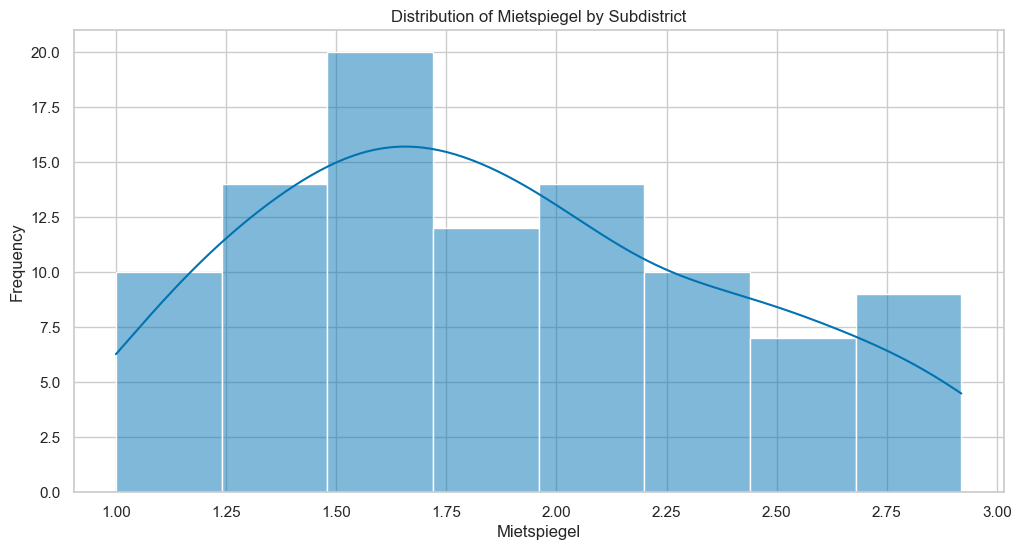

In [60]:
plt.figure(figsize=(12, 6))
sns.histplot(ortsteil_master["subdistrict_avg_mietspiegel_classification"], kde=True)
plt.title("Distribution of Mietspiegel by Subdistrict")
plt.xlabel("Mietspiegel")
plt.ylabel("Frequency")
plt.show()

🔖 *The most frequent mietspiegel class is beteen 1.50 and 1.75. Higher mietspiegel classes from around 2.50 are less frequent.*

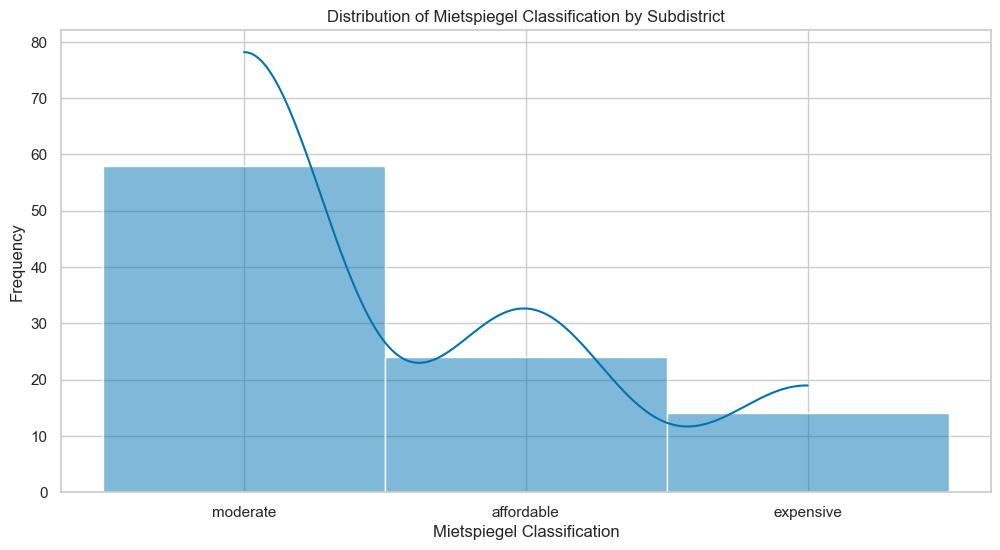

In [61]:
plt.figure(figsize=(12, 6))
sns.histplot(ortsteil_master["classification_category"], kde=True)
plt.title("Distribution of Mietspiegel Classification by Subdistrict")
plt.xlabel("Mietspiegel Classification")
plt.ylabel("Frequency")
plt.show()

🔖 *Subdistricts with an avarage mietspiegel class of 'moderate' or most common.*

# Demographics & Popultion Structure

We explore subdistrict-level demographics, focusing on **age shares** and **employment**.

Text(0, 0.5, '')

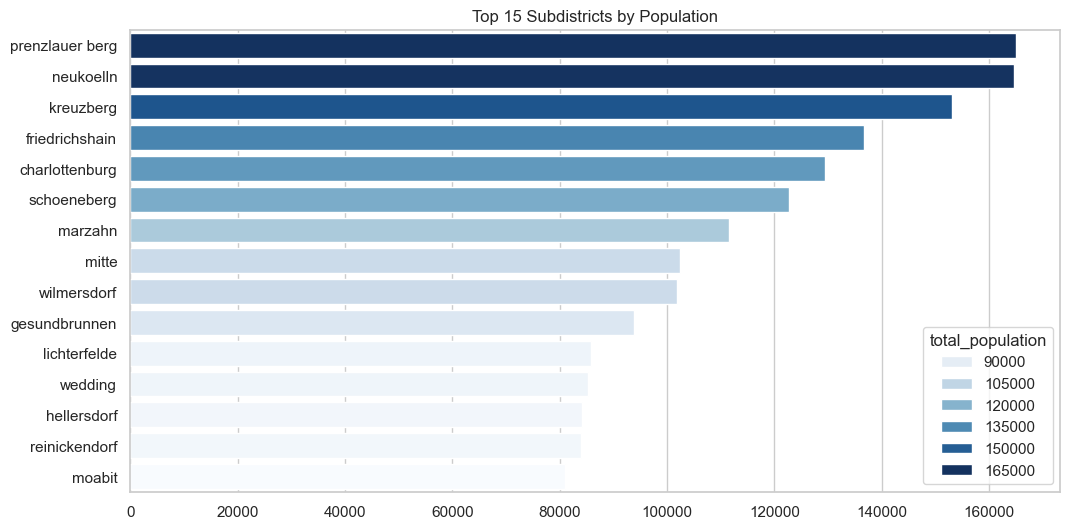

In [62]:
# Top 15 subdistricts by population
ortsteil_population = ortsteil_master.groupby("ortsteil")["total_population"].sum().reset_index()
ortsteil_population = ortsteil_population.sort_values(by="total_population", ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x="total_population", y="ortsteil", data=ortsteil_population, hue="total_population", palette="Blues")
plt.title("Top 15 Subdistricts by Population")
plt.xlabel("")
plt.ylabel("")

*🔖 **Prenzlauer Berg** and **Neuköln** are the subdistrict with the highest total population, closely followed by **Kreuzberg**.*

Text(0, 0.5, '')

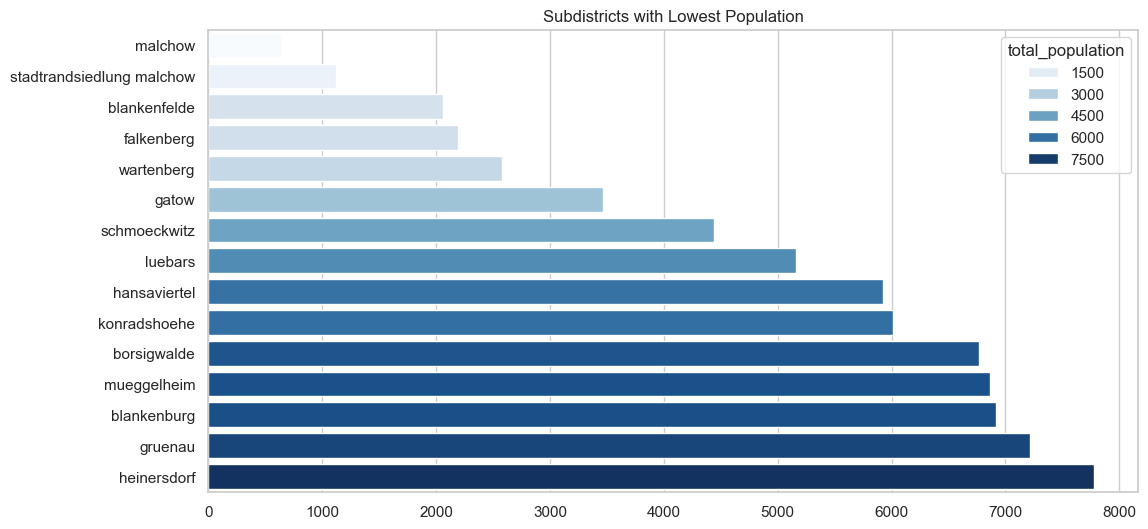

In [63]:
# top 15 subdistricts by population ascending
ortsteil_population = ortsteil_master.groupby("ortsteil")["total_population"].sum().reset_index()
ortsteil_population = ortsteil_population.sort_values(by="total_population", ascending=True).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x="total_population", y="ortsteil", data=ortsteil_population, hue="total_population", palette="Blues")
plt.title("Subdistricts with Lowest Population")
plt.xlabel("")
plt.ylabel("")

*🔖 **Malchow** is the subdistrict with the smalles population below 1000 people.*

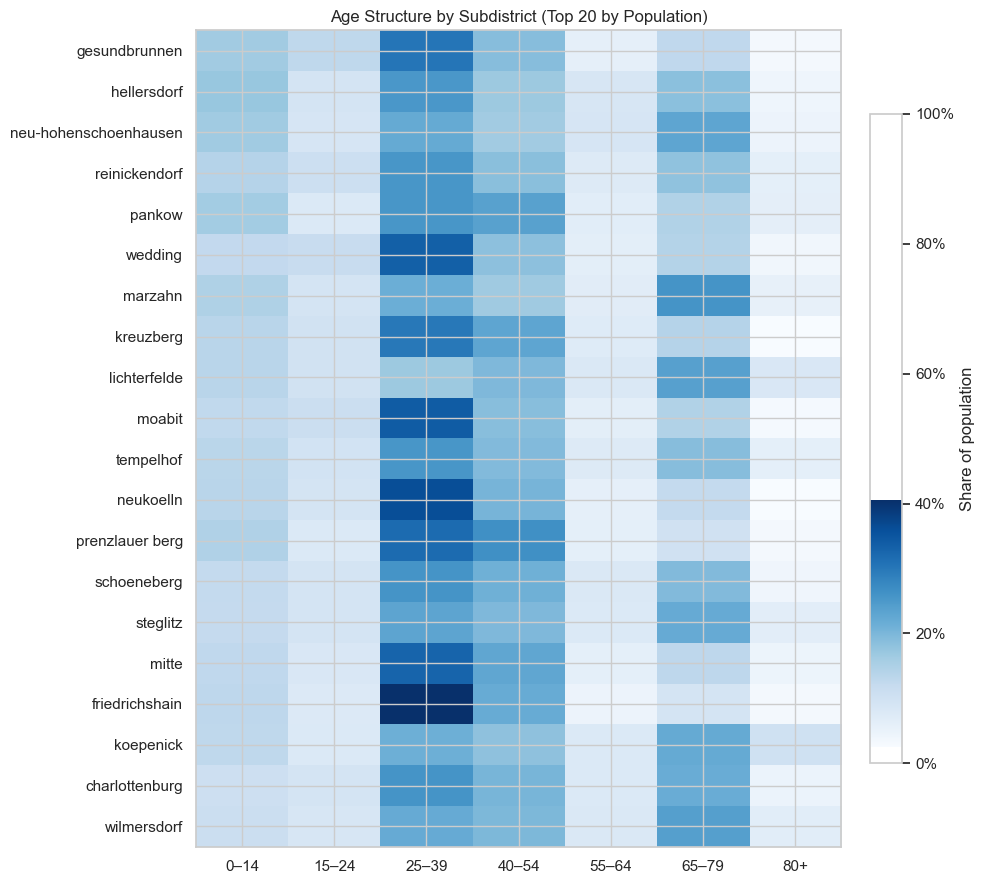

In [64]:
# Age Groups
plt.figure(figsize=(10, 9))
im = plt.imshow(hm.values, aspect='auto', interpolation='nearest', cmap='Blues')
plt.title('Age Structure by Subdistrict (Top 20 by Population)')
plt.yticks(range(len(hm.index)), hm.index)
plt.xticks(range(len(hm.columns)), hm.columns, rotation=0)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Share of population')
# show 0–100% ticks
cbar_ticks = np.linspace(0, 1, 6)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels([f'{int(t*100)}%' for t in cbar_ticks])

plt.tight_layout()
plt.show()

🔖  **Key Insights**
* *Subdistricts such as **Neukölln**, **Mitte**, **Friedrichshain**, and **Prenzlauer Berg** stand out with high shares of residents in the 25–39 group, reflecting their popularity among young adults.*
* *Outer districts like **Hellersdorf**, **Marzahn**, **Reinickendorf** show a more balanced or older demographic profile, with relatively higher shares in the 55–64 and 65–79 groups.*
* *The youth share (0–14, 15–24) is more pronounced in family-oriented areas such as **Köpenick** and **Wedding**, while central trendy areas show lower youth representation.*
* *The 80+ share is more visible in some western subdistricts, **Charlottenburg** and **Wilmersdorf**, aligning with known patterns of older resident concentrations.*

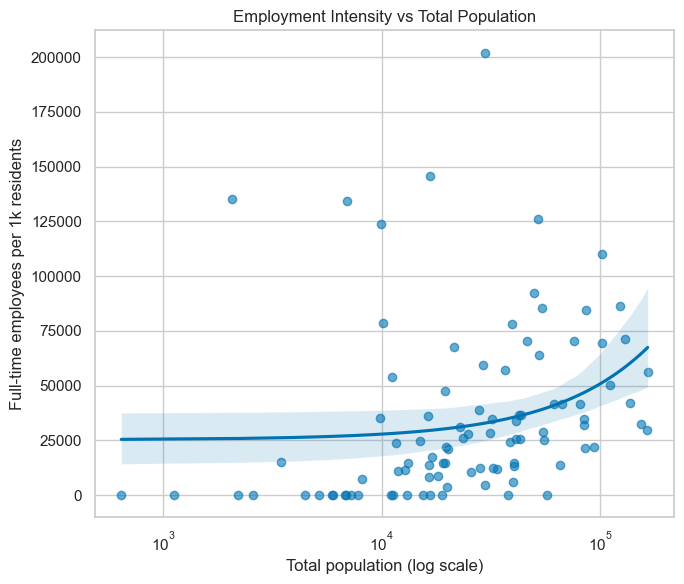

In [65]:
# Employment vs Total Population
tmp = ortsteil_master[ortsteil_master['total_population']>0].copy()
tmp['employees_per_1k'] = 1000 * tmp['subdistrict_total_full_time_employees'] / tmp['total_population']

plt.figure(figsize=(7,6))
sns.regplot(data=tmp, x='total_population', y='employees_per_1k', scatter_kws={'alpha':0.6})
plt.xscale('log')
plt.title('Employment Intensity vs Total Population')
plt.xlabel('Total population (log scale)')
plt.ylabel('Full-time employees per 1k residents')
plt.tight_layout()
plt.show()

🔖 **Key Insights**

* **Non-linear relationship**: Employment intensity (full-time employees per 1k residents) shows a generally increasing trend with population size, but the relationship is not linear. A log scale helps reveal that larger subdistricts tend to host proportionally more jobs.

* **Outliers**: Several subdistricts (likely central business hubs such as Mitte or Charlottenburg) exhibit extremely high employment intensity, far above the general trend. These are areas where jobs concentrate more than residents.
* **Peripheral areas**: Smaller and mid-sized subdistricts often show low employment intensity, highlighting their primarily residential function.
* Diversity across similar populations: Subdistricts with similar total populations can differ significantly in employment intensity, reflecting differences in urban planning (e.g., mixed-use centers vs. dormitory suburbs).
* **Implication for affordability modeling**: Employment hotspots may attract higher demand for housing (raising rents), but they also define important urban-economic profiles that should be factored into clustering and recommendations.


# Affordability (Rent vs. Income)

This section investigates affordability by comparing **average rent per m²** with **household income**. We can spot which Ortsteile are most and least affordable, providing a basis for later affordability classification.

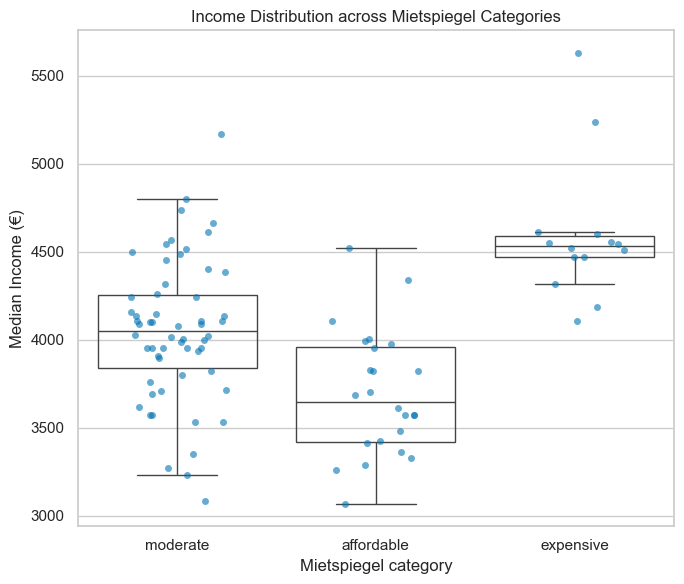

In [66]:
# Using Mietspiegel classification (ordinal) vs income:
plt.figure(figsize=(7,6))
sns.stripplot(data=ortsteil_master, x='classification_category', y='subdistrict_avg_median_income_eur', jitter=0.25, alpha=0.6)
sns.boxplot(data=ortsteil_master, x='classification_category', y='subdistrict_avg_median_income_eur',
            showcaps=True, boxprops={'facecolor':'none'}, showfliers=False, whis=1.5)
plt.title('Income Distribution across Mietspiegel Categories')
plt.xlabel('Mietspiegel category')
plt.ylabel('Median Income (€)')
plt.tight_layout()
plt.show()

🔖 **Key Insights**

* **Clear stratification**: Districts classified as expensive in the Mietspiegel tend to have higher median incomes than both moderate and affordable categories, reinforcing the link between rent levels and local purchasing power.

* **Moderate vs. affordable mismatch**: Interestingly, the moderate category shows slightly higher median incomes than the affordable category on average. This suggests that affordability isn’t strictly aligned with income — some “affordable” rent areas are also home to lower-income populations.

* **Wider spread in affordable areas**: The affordable category has the broadest income distribution, ranging from some of the lowest to mid-level incomes, reflecting more socioeconomic diversity within these neighborhoods.

* **Expensive districts show consistency**: The expensive category has a narrower distribution, with incomes clustered at the higher end, implying relatively homogeneous wealthier populations.

* **Implications**: These patterns confirm that rent affordability is contextual — income levels alone don’t fully explain affordability categories, which are shaped by both market dynamics and socio-spatial distribution.

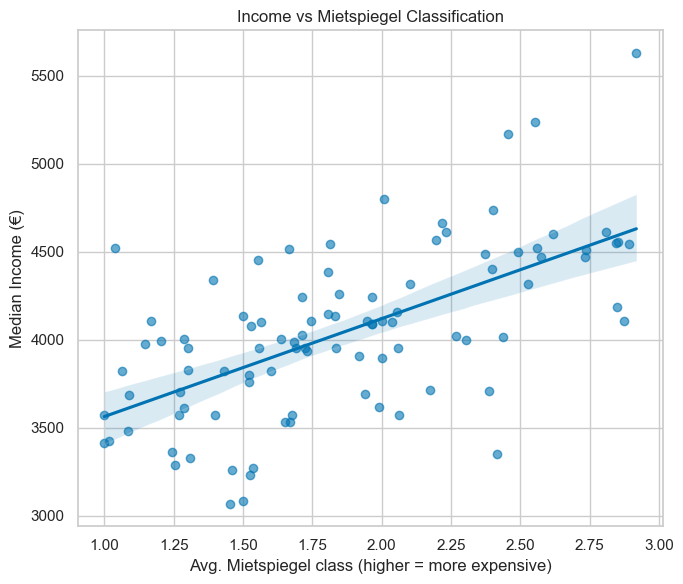

In [67]:
# Income vs Mietspiegel
plt.figure(figsize=(7,6))
sns.regplot(data=ortsteil_master, x='subdistrict_avg_mietspiegel_classification',
            y='subdistrict_avg_median_income_eur', scatter_kws={'alpha':0.6})
plt.title('Income vs Mietspiegel Classification')
plt.xlabel('Avg. Mietspiegel class (higher = more expensive)')
plt.ylabel('Median Income (€)')
plt.tight_layout()
plt.show()

🔖 **Key Insights**

* **Strong positive relationship**: There is a clear upward trend — subdistricts with a higher Mietspiegel classification (more expensive rent categories) also tend to have higher median incomes.

* **Income alignment with rent**: This correlation suggests that more expensive rental markets are typically concentrated in wealthier neighborhoods, reinforcing socioeconomic stratification in Berlin.

* **Variation exists**: Despite the overall positive trend, there is still considerable scatter: some subdistricts with moderate Mietspiegel classes show both low and relatively high incomes, reflecting diverse socioeconomic mixes.

* **Predictive value**: The strength of the relationship indicates Mietspiegel classification can serve as a useful proxy for affordability modeling, as it captures both housing cost and local income dynamics.

* **Policy relevance**: The alignment of higher incomes with more expensive Mietspiegel categories underlines the challenge for lower-income groups in accessing housing in prime areas.

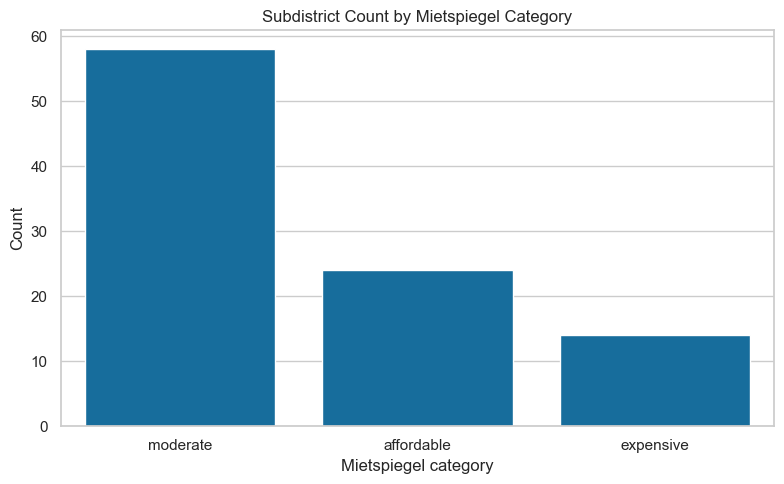

In [68]:
# Subdistrict count by Mietspiegel category
plt.figure(figsize=(8,5))
order = ortsteil_master['classification_category'].value_counts().index
sns.countplot(data=ortsteil_master, x='classification_category', order=order)
plt.title('Subdistrict Count by Mietspiegel Category')
plt.xlabel('Mietspiegel category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

🔖 **Key Insights**

* **Majority are moderate**: Most Berlin subdistricts fall into the moderate Mietspiegel category, showing that the rental market is not uniformly extreme but centered around middle-range costs.

* **Affordable is less common**: Only about a quarter of subdistricts are classified as affordable, underlining the limited availability of truly low-cost housing across the city.

* **Expensive is concentrated**: A relatively small number of subdistricts are in the expensive category, suggesting that high-cost housing is geographically concentrated in specific areas (likely central, high-demand neighborhoods).

* **Implications for housing seekers**: While moderate areas dominate, the scarcity of affordable subdistricts highlights the difficulty for low-income households to find housing, reinforcing the importance of affordability classification in this project.

# Amenities & Local Infrastructure (POIs)

This section covers the distribution of amenities and services at the Ortsteil level. Access to **cultural**, **social**, and **recreational** POIs helps us distinguish neighborhood profiles beyond just affordability.

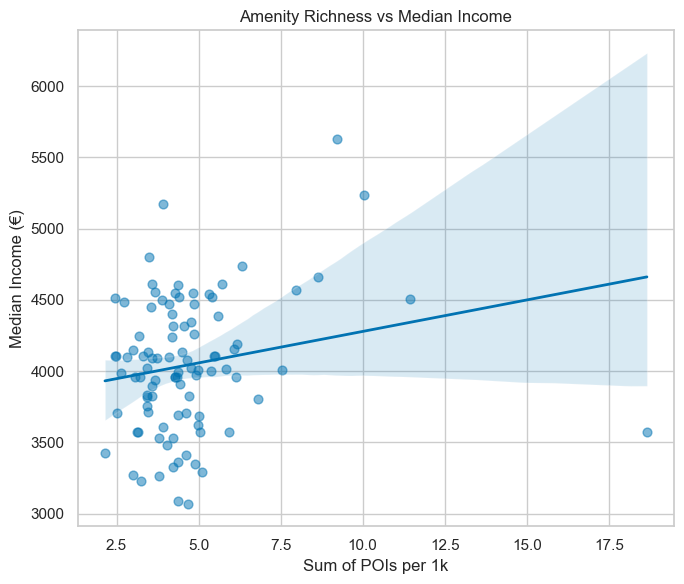

In [ ]:
# Define POI columns 
poi_cols = [c for c in poi_per_1k.columns if c not in id_cols and np.issubdtype(poi_per_1k[c].dtype, np.number)]

# Build amenity richness (sum of POIs per 1k)
tmp = poi_per_1k.copy()
tmp['amenity_richness'] = tmp[poi_cols].sum(axis=1, skipna=True)

# Bring in income (and rent if you want later) 
need_cols = ['subdistrict_avg_median_income_eur']
df_plot = tmp.merge(ortsteil_master[id_cols + need_cols], on=id_cols, how='left')
df_plot = df_plot.dropna(subset=['amenity_richness', 'subdistrict_avg_median_income_eur'])

# Scatter with regression line
plt.figure(figsize=(7,6))
sns.regplot(
    data=df_plot, x='amenity_richness', y='subdistrict_avg_median_income_eur',
    scatter_kws={'alpha':0.5, 's':40}, line_kws={'lw':2}
)
plt.title('Amenity Richness vs Median Income')
plt.xlabel('Sum of POIs per 1k')
plt.ylabel('Median Income (€)')
plt.tight_layout()
plt.show()

🔖 **Key Insights**

* **Weak positive relationship**: There is a slight upward trend, indicating that subdistricts with more amenities per 1,000 residents tend to have somewhat higher median incomes. However, the relationship is weak and not consistent.

* **High variation at low POI levels**: Many subdistricts cluster at the low end of amenity richness (under 20 POIs per 1,000 residents), but these neighborhoods still span a wide range of incomes. This suggests that amenity access is not exclusively tied to wealth.

* **Outliers with high amenities**: A few subdistricts with unusually high POI density also have relatively high incomes, likely representing central or culturally vibrant neighborhoods.

* **Uncertainty increases with POI density**: The broad confidence interval at higher POI counts reflects fewer data points and more variability, meaning conclusions for highly amenity-rich areas should be cautious.

* **Implication for modeling**: While amenity richness adds context, it is not a strong standalone predictor of income. It should instead be combined with other socioeconomic and housing variables in clustering and recommendation models.


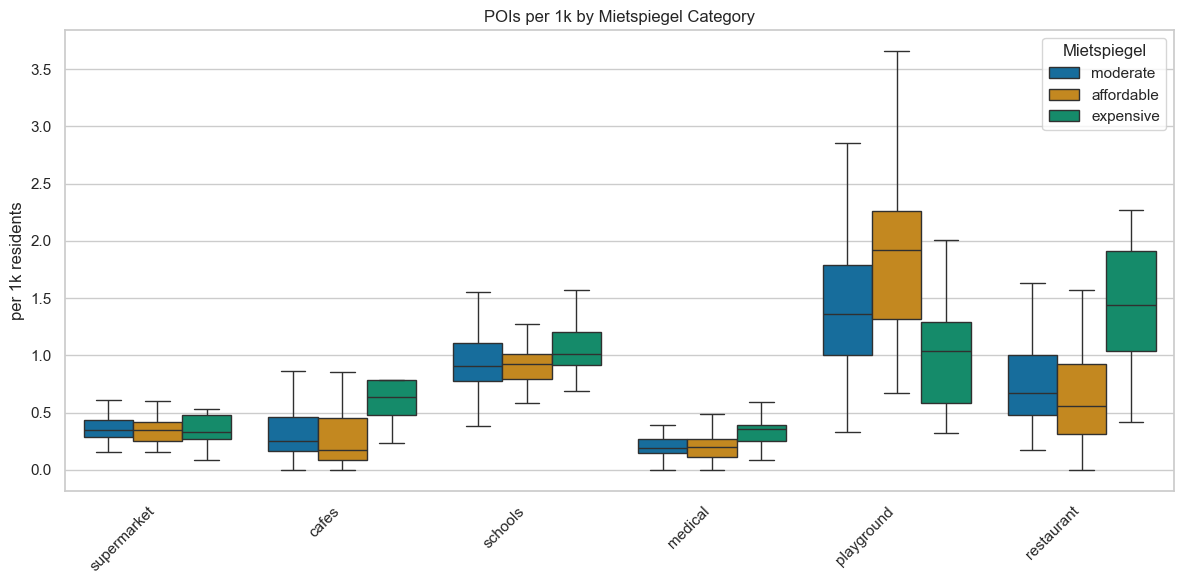

In [ ]:
sel = ['supermarket','cafes','schools','medical','playground','restaurant']
long = (poi_per_1k[id_cols + sel]
        .merge(ortsteil_master[id_cols + ['classification_category']], on=id_cols)
        .melt(id_vars=id_cols + ['classification_category'], var_name='poi', value_name='per_1k'))

plt.figure(figsize=(12,6))
sns.boxplot(data=long, x='poi', y='per_1k', hue='classification_category', showfliers=False)
plt.title('POIs per 1k by Mietspiegel Category')
plt.xlabel('')
plt.ylabel('per 1k residents')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Mietspiegel')
plt.tight_layout()
plt.show()

🔖 **Key Insights**

* **Amenities differ by Mietspiegel category**: Expensive subdistricts tend to have higher densities of cafes and restaurants, aligning with their reputation as lifestyle and leisure hubs.

* **Schools are evenly distributed**: School availability per 1,000 residents is fairly balanced across categories, showing that educational infrastructure is more evenly spread in Berlin.

* **Playgrounds higher in affordable areas**: Interestingly, affordable subdistricts show a higher concentration of playgrounds per capita, possibly reflecting more family-oriented neighborhoods.

* **Supermarkets & medical facilities**: These POIs remain relatively stable across categories, suggesting that basic daily needs are not strongly differentiated by rent level.

* **Variation is significant**: Within each Mietspiegel category, the spread of POI counts is large, meaning that local neighborhood amenities vary widely even in similarly priced housing areas.


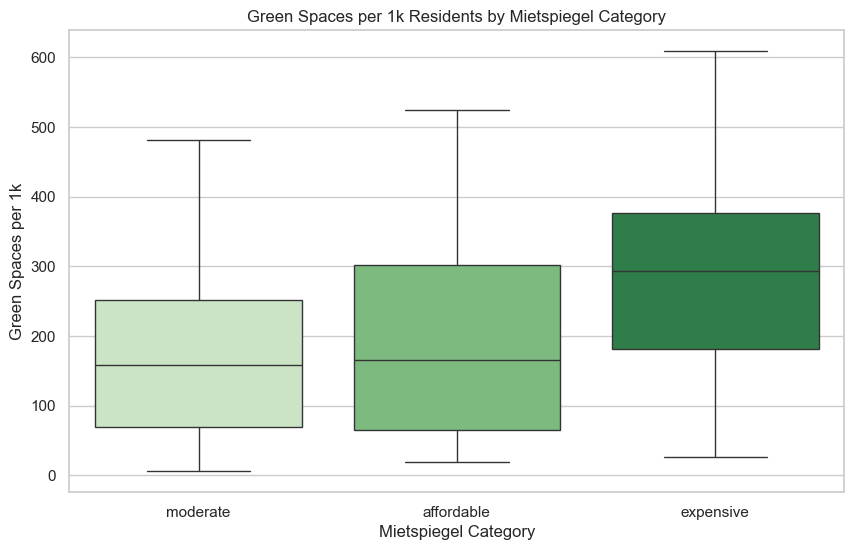

In [ ]:
# Green spaces
plt.figure(figsize=(10,6))
sns.boxplot(
    data=ortsteil_master,
    x='classification_category',   # Mietspiegel classes on x-axis
    y='green_space',               # number of green spaces per 1k (already normalized)
    showfliers=False,
    hue='classification_category',
    palette='Greens'
)
plt.title('Green Spaces per 1k Residents by Mietspiegel Category')
plt.xlabel('Mietspiegel Category')
plt.ylabel('Green Spaces per 1k')
plt.show()

🔖 **Key Insights**

* **Expensive areas have the most green space per capita**: Subdistricts in the expensive Mietspiegel category typically enjoy the highest access to green space per 1,000 residents, suggesting a link between wealthier neighborhoods and environmental amenities.

* **Affordable areas are mixed**: Affordable subdistricts show a wide variation — some offer generous green space, while others provide very little, reflecting uneven distribution of environmental quality in lower-rent areas.

* **Moderate areas lag behind**: Subdistricts in the moderate category generally have the least green space per capita, indicating that middle-range rent areas may balance density with fewer environmental amenities.

* **High variability overall**: Each category has a broad spread, showing that green space availability is not uniform within rent categories and depends heavily on local planning and geography.

* **Implications for affordability & quality of life**: Green space access emerges as an important dimension beyond rent and income. While some affordable areas offer good environmental quality, residents in moderate areas may face trade-offs between rent and access to nature.

# Relationships Between Variables

Using correlation heatmaps and scatterplots, we analyze how features relate (e.g., rent vs. income, population vs. households). This helps identify redundant variables and meaningful feature combinations.

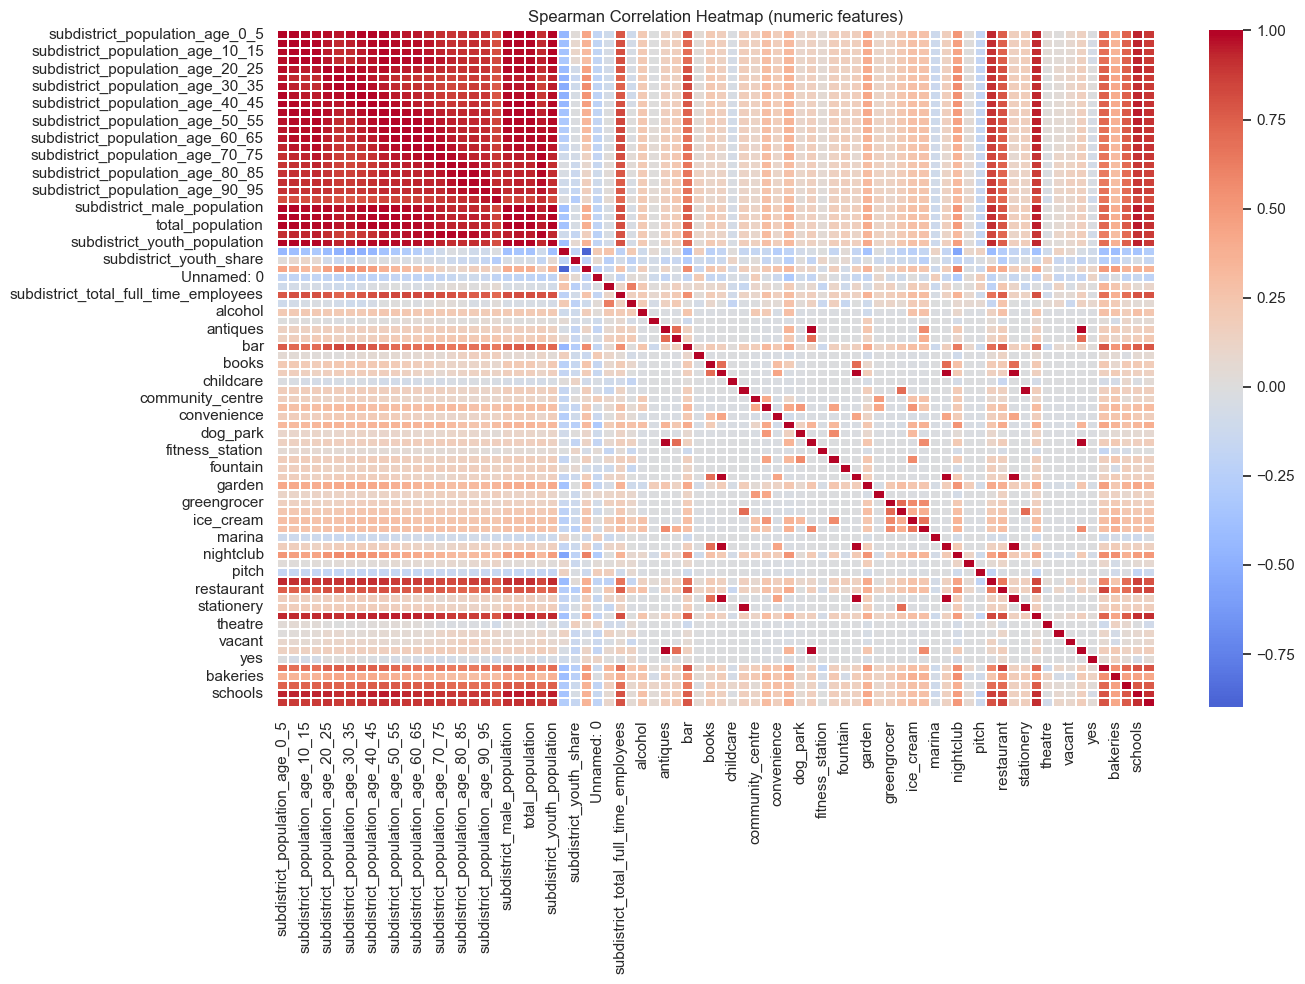

In [ ]:
num_cols = [c for c in ortsteil_master.columns if ortsteil_master[c].dtype != 'O']  # numeric only
corr = ortsteil_master[num_cols].corr(method='spearman')

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.2)
plt.title('Spearman Correlation Heatmap (numeric features)')
plt.tight_layout()
plt.show()

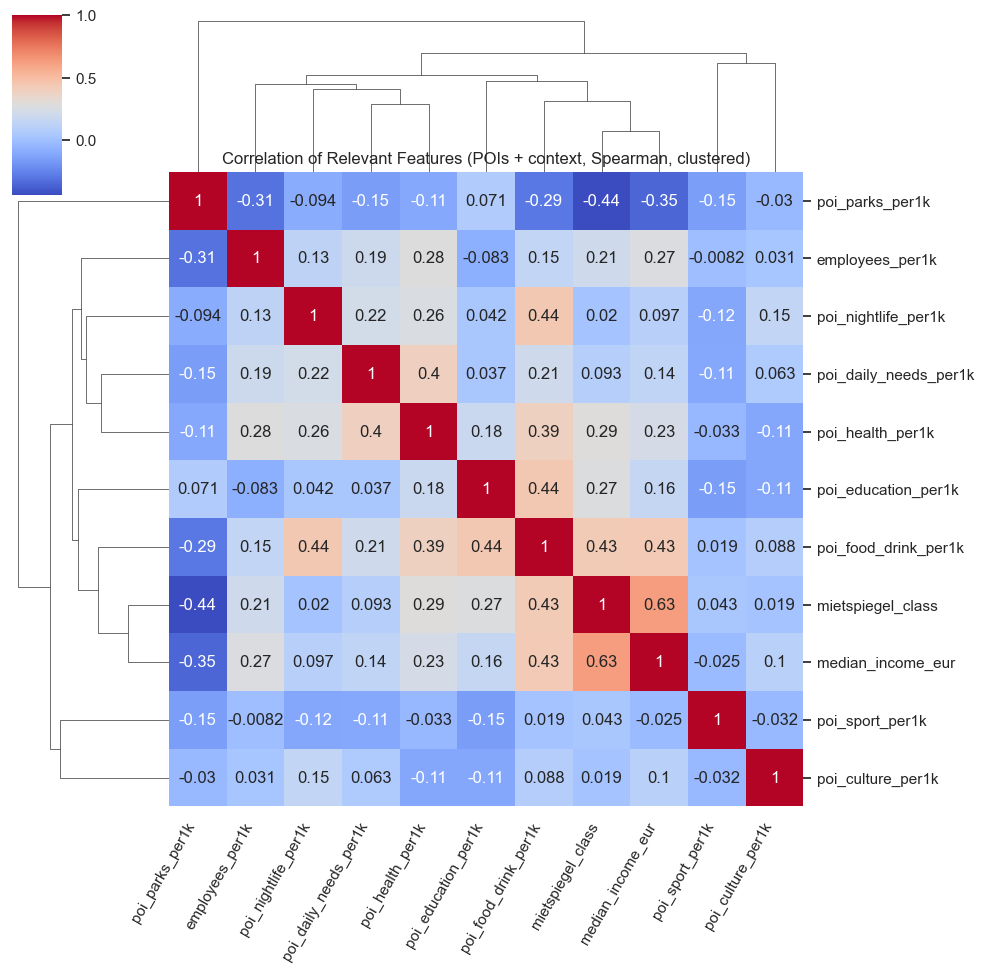

In [ ]:
df = ortsteil_master.copy()
df["total_population"] = df["total_population"].replace(0, np.nan)

features = pd.DataFrame(index=df.index)

# POI groups per 1k residents
for group, parts in POI_GROUPS.items():
    poi_cols = [c for c in df.columns if any(p == c or p in c for p in parts)]
    if poi_cols:
        features[f"poi_{group}_per1k"] = 1000 * df[poi_cols].sum(axis=1) / df["total_population"]

# Core context (add if present)
if "subdistrict_avg_mietspiegel_classification" in df.columns:
    features["mietspiegel_class"] = df["subdistrict_avg_mietspiegel_classification"]

if "subdistrict_avg_median_income_eur" in df.columns:
    features["median_income_eur"] = df["subdistrict_avg_median_income_eur"]

# Employment intensity per 1k (if column exists)
if "subdistrict_total_full_time_employees" in df.columns:
    features["employees_per1k"] = 1000 * df["subdistrict_total_full_time_employees"] / df["total_population"]

# Population density (optional if area available)
if "area_km2" in df.columns:
    features["pop_density_per_km2"] = df["total_population"] / df["area_km2"].replace(0, np.nan)

# Clean up: drop all-NaN/constant cols and infinities
features = (features.replace([np.inf, -np.inf], np.nan)
                    .dropna(axis=1, how="all"))
const_cols = [c for c in features.columns if features[c].nunique(dropna=True) <= 1]
features = features.drop(columns=const_cols)

# ----- Spearman clustermap of relevant features -----
corr = features.corr(method="spearman")

g = sns.clustermap(
    corr, cmap="coolwarm", annot=True
)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60, ha="right")
g.ax_heatmap.set_title("Correlation of Relevant Features (POIs + context, Spearman, clustered)")
plt.show()

🔖 **Key Insights**
* **Income & Mietspiegel strongly correlated (ρ ≈ 0.63)**: Wealthier subdistricts also tend to have higher Mietspiegel classifications, confirming that rental prices align with local purchasing power.

* **Food & daily needs POIs align with context variables**: poi_food_drink_per1k and poi_daily_needs_per1k show positive correlations with both income and Mietspiegel, suggesting that amenity-rich neighborhoods also skew more expensive.

* **Employment intensity modestly linked to POIs**: Areas with more employees per capita show weak to moderate positive correlations with certain POIs (e.g., daily needs, food/drink), consistent with denser, mixed-use environments.

* **Parks & nightlife stand apart**: poi_parks_per1k and poi_nightlife_per1k show weaker or even negative correlations with core socioeconomic variables, reflecting that green space access and nightlife are not tightly bound to income or rent levels.

* **Education & health POIs are neutral**: These services remain more evenly distributed across subdistricts regardless of rent or income, implying they are less tied to affordability patterns.


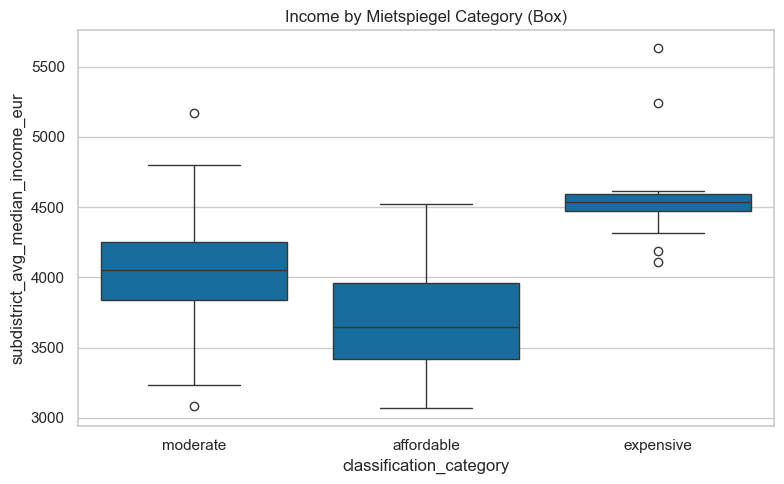

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=ortsteil_master, x='classification_category', y='subdistrict_avg_median_income_eur', showfliers=True)
plt.title('Income by Mietspiegel Category (Box)')
plt.tight_layout(); plt.show()

🔖 **Key Insights**

* **Clear income stratification**: Subdistricts in the expensive Mietspiegel category consistently show the highest median incomes, confirming that higher rents align with wealthier neighborhoods.

* **Affordable category lowest**: The affordable category has the lowest incomes overall, with a wide spread that includes some of the lowest values in the dataset. This reflects the socioeconomic diversity of cheaper areas.

* **Moderate overlaps both sides**: The moderate category sits between the two extremes but with overlap on both sides, meaning that some moderate-rent areas host relatively affluent populations, while others are closer to affordable levels.

* **Distribution differences**:

  * `Expensive` → Narrower range, incomes clustered tightly at the high end.
  * `Affordable` → Broadest spread, suggesting mixed economic conditions.
  * `Moderate` → Midpoint, bridging the gap.
 
 * **Affordability implication**: The alignment of higher Mietspiegel categories with higher incomes suggests that market prices reflect local purchasing power, but the overlap between categories also indicates areas where rent and income are not perfectly matched.